Loading SPY data from data/2024-11-24/SPY.csv


[*********************100%%**********************]  1 of 1 completed


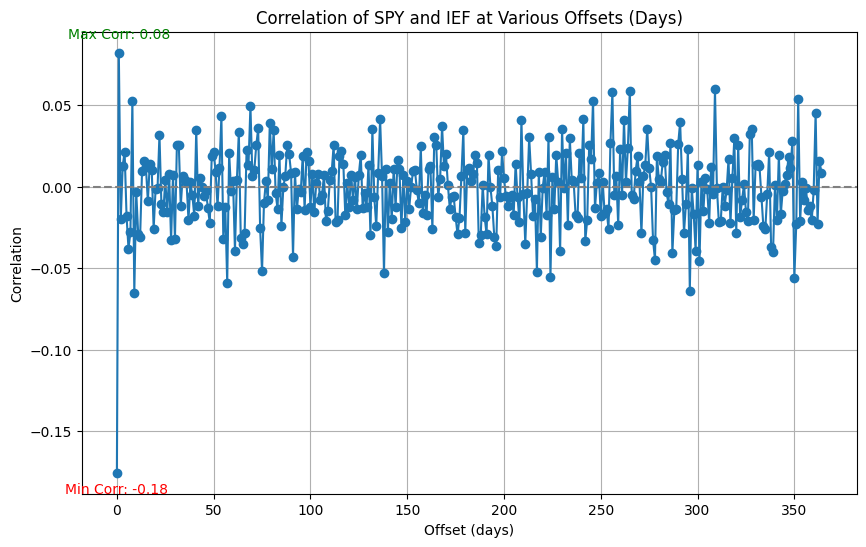

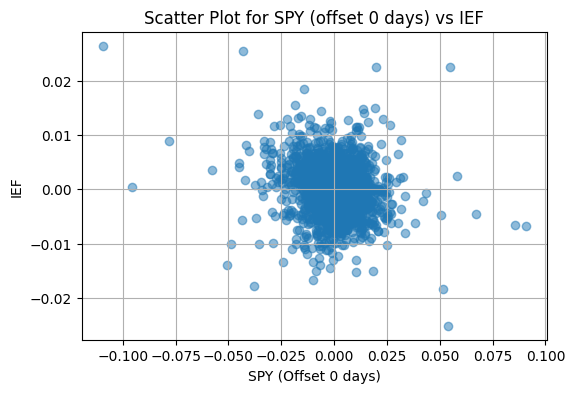

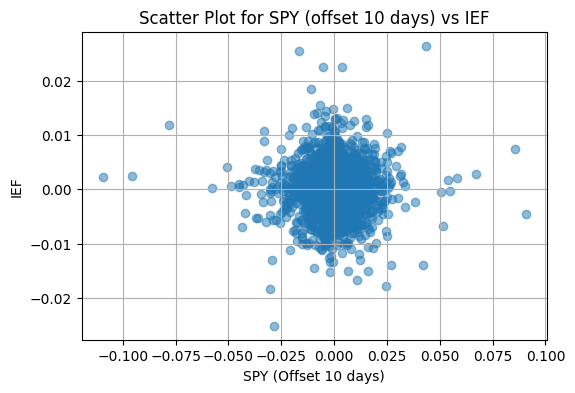

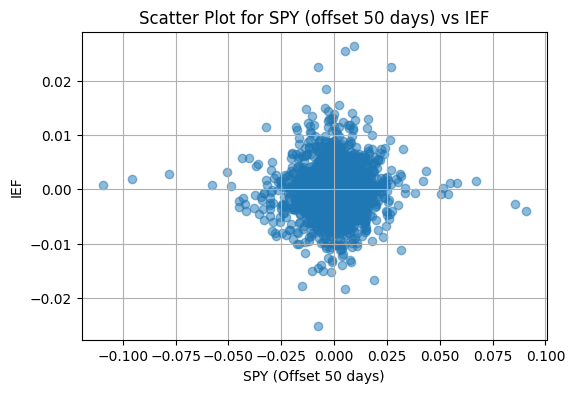

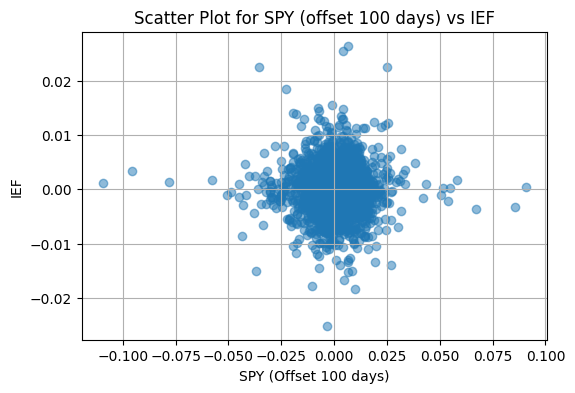

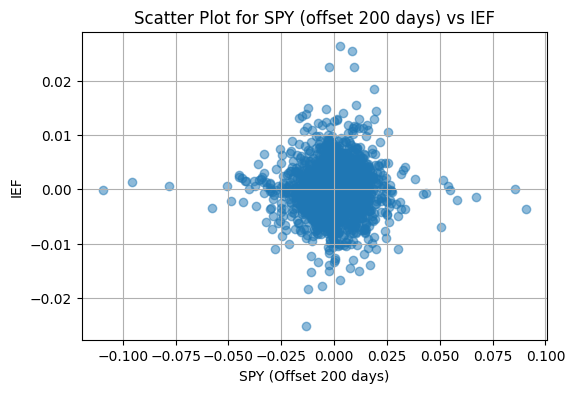

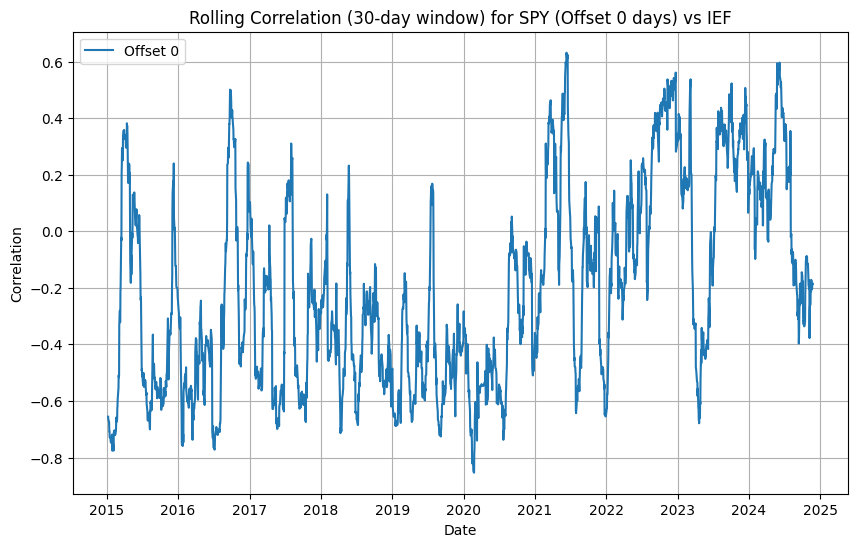

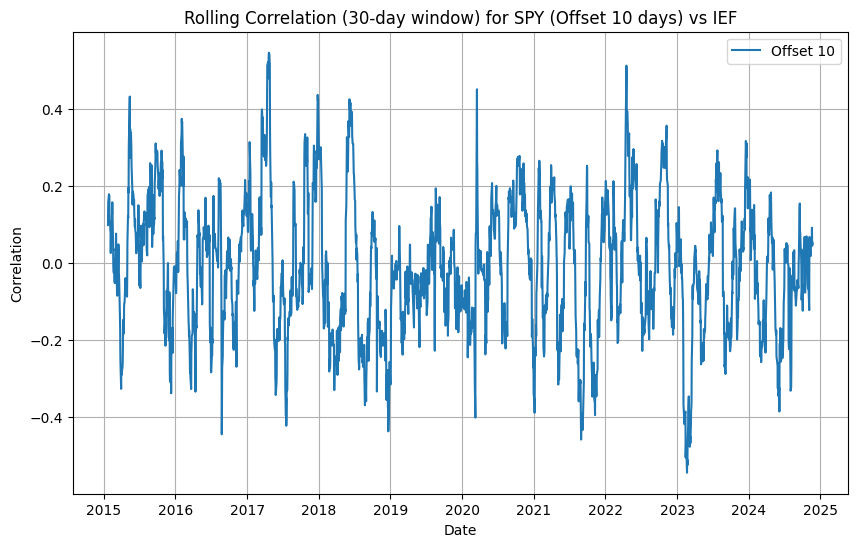

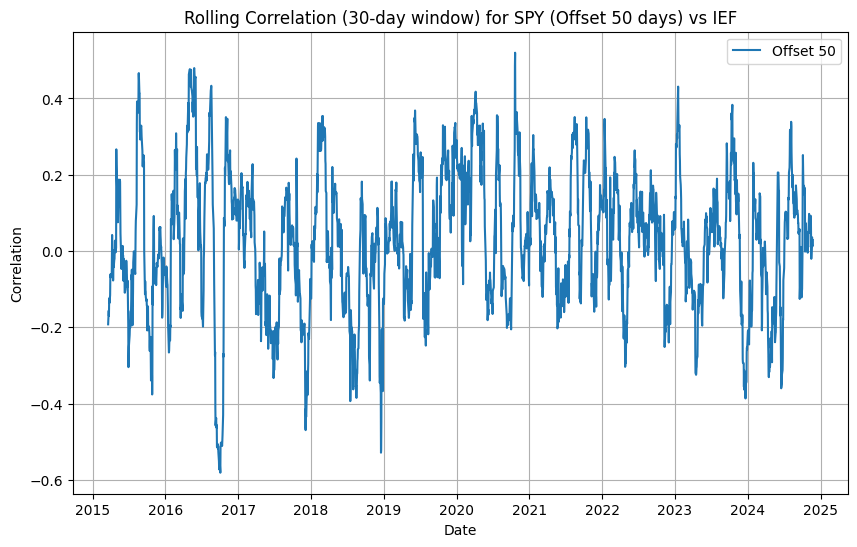

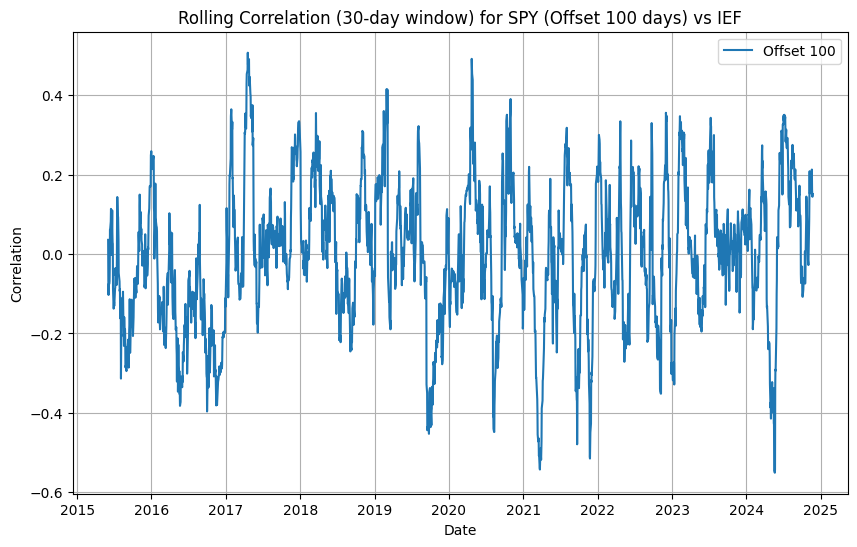

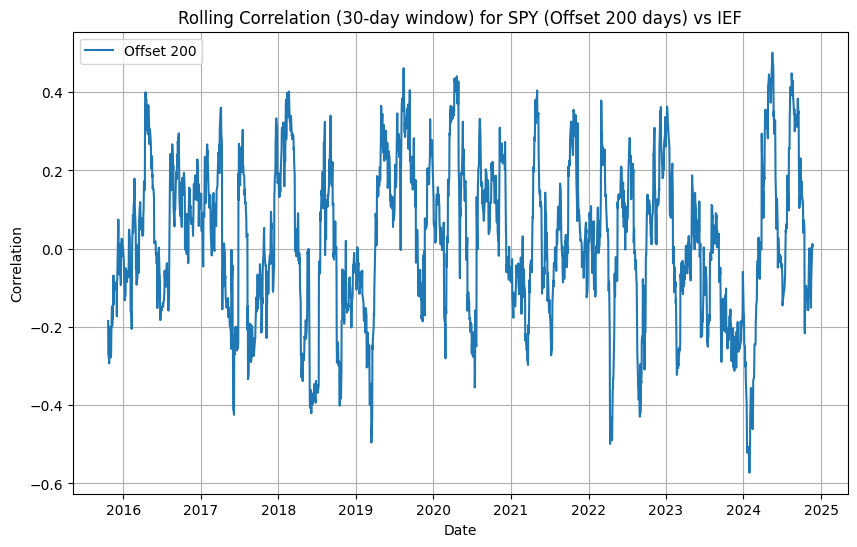

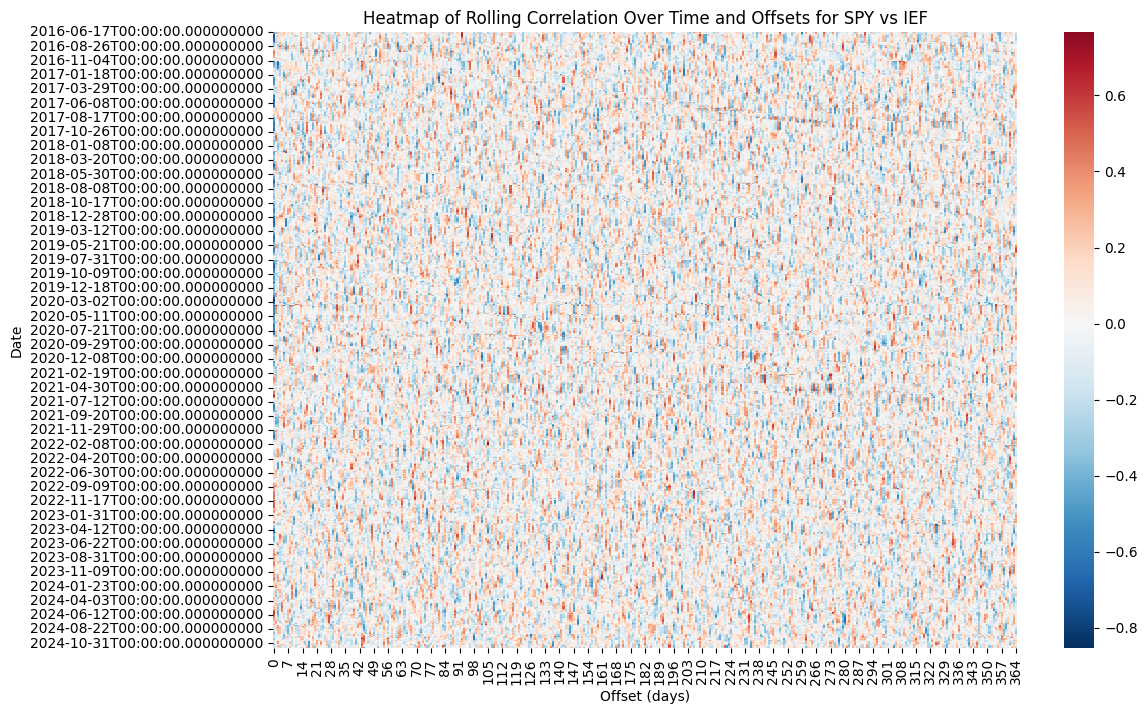

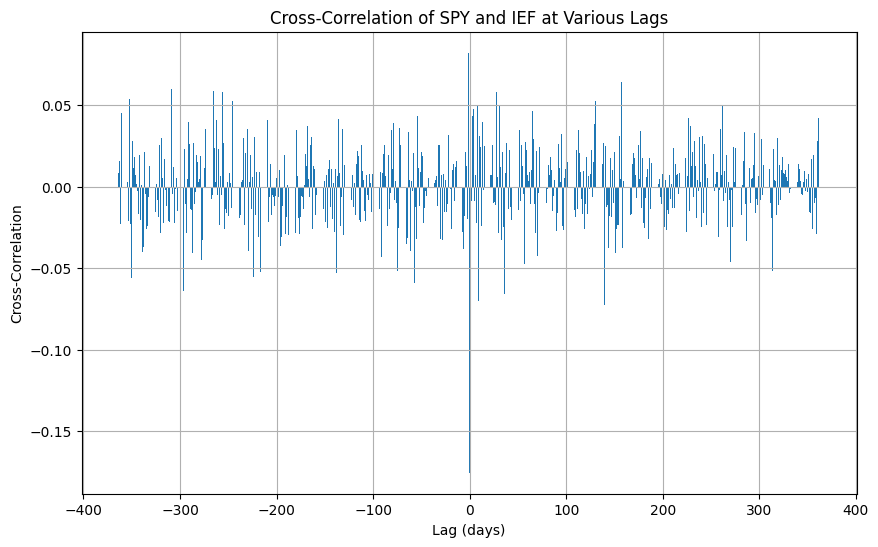

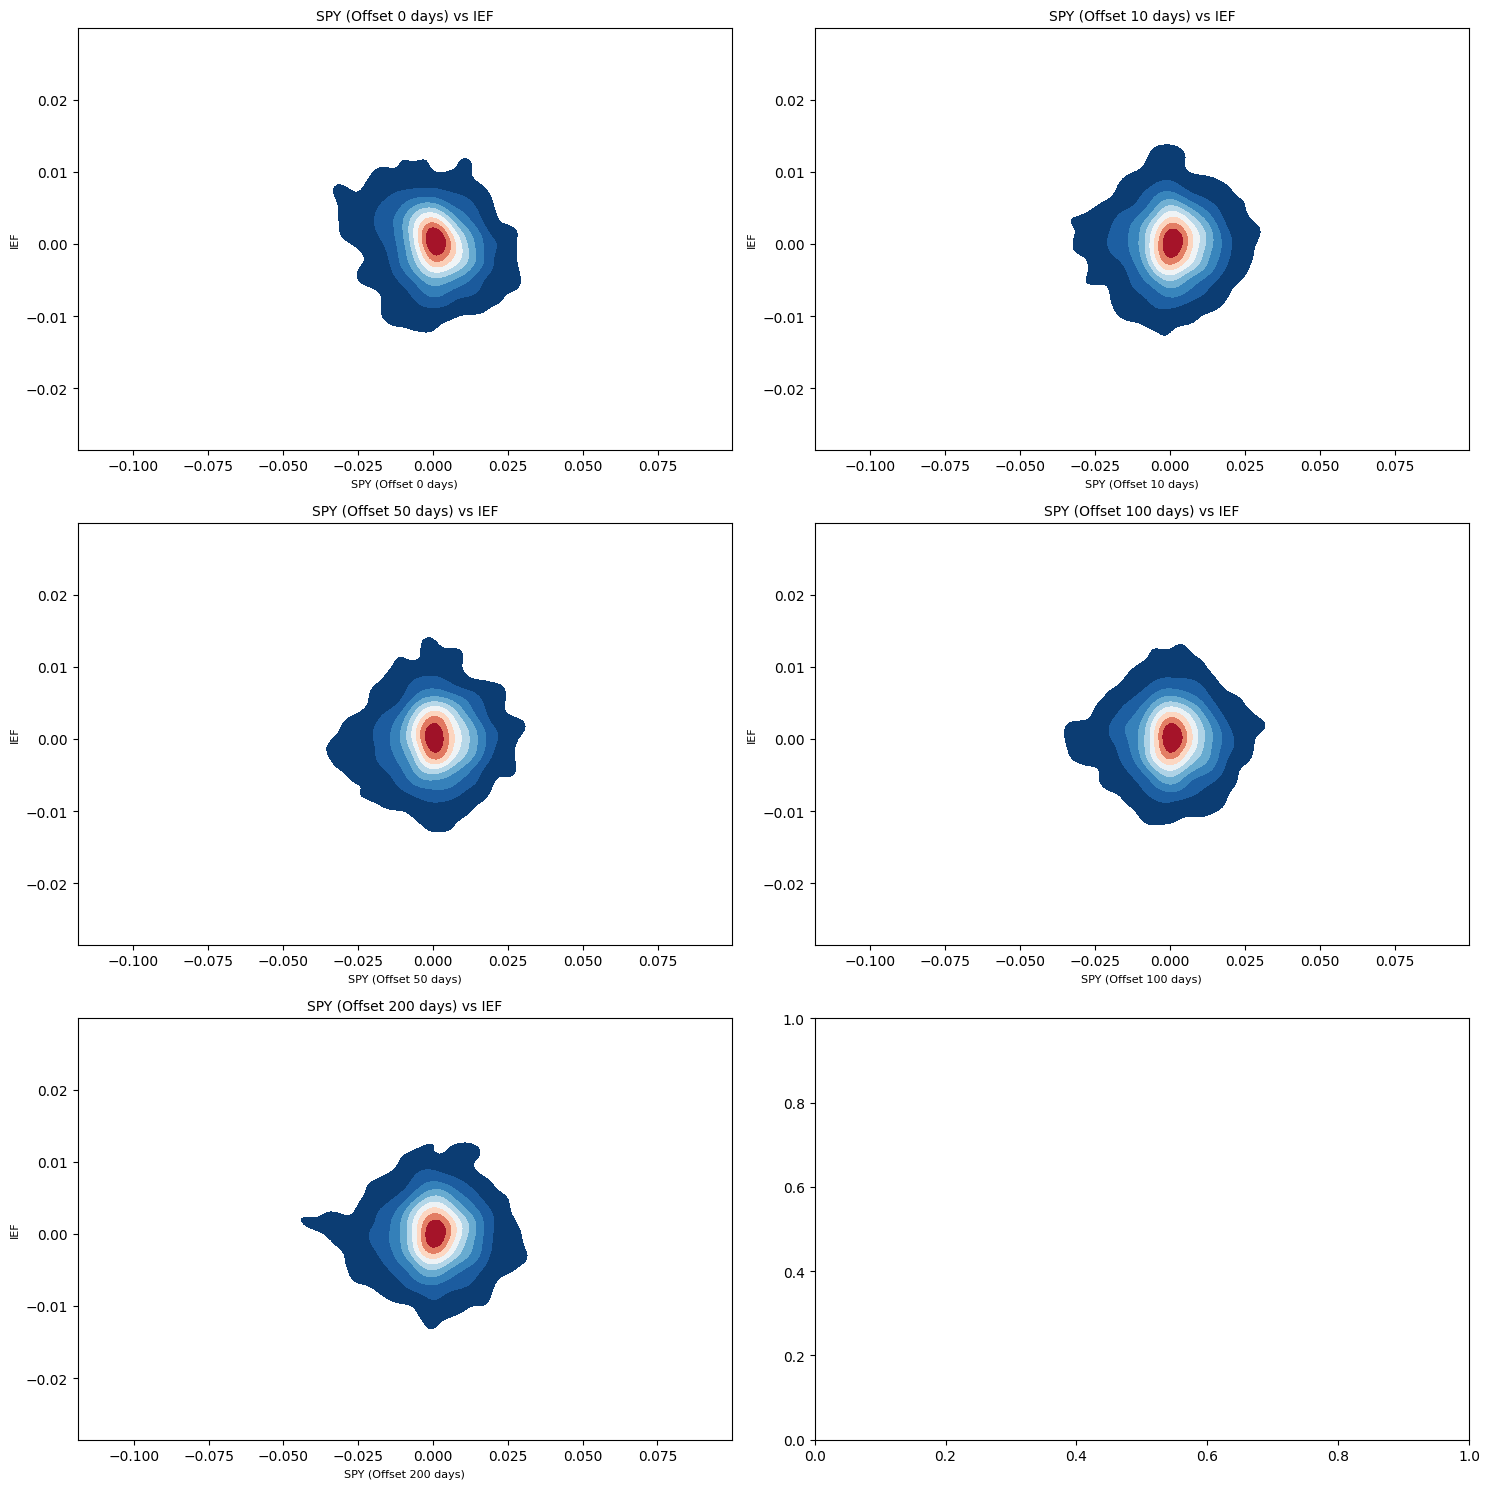

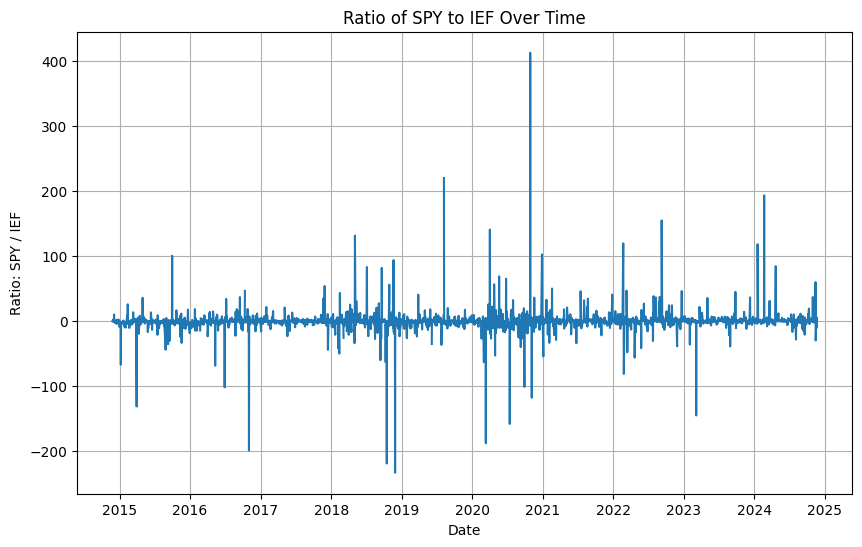

Correlation calculations and visualizations complete for SPY and IEF.


In [1]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set the default tickers
tickera = "SPY"
tickerb = "IEF"

# Create a folder for today's date, organized by tickers
today = datetime.today().strftime('%Y-%m-%d')
base_folder = f"output/{tickera}_{tickerb}/{today}"
data_folder = f"data/{today}"
os.makedirs(data_folder, exist_ok=True)
os.makedirs(base_folder, exist_ok=True)

# Function to download or load cached data
def get_data(ticker):
    file_path = f"{data_folder}/{ticker}.csv"
    
    # Check if file already exists
    if os.path.exists(file_path):
        print(f"Loading {ticker} data from {file_path}")
        return pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        print(f"Downloading {ticker} data and saving to {file_path}")
        df = yf.download(ticker, period='10y')
        df.to_csv(file_path)
        return df

# Download or load data for tickera and tickerb
df_a = get_data(tickera)
df_b = get_data(tickerb)

# Ensure both have 'Adj Close' prices
if 'Adj Close' not in df_a.columns or 'Adj Close' not in df_b.columns:
    raise ValueError(f"One or both tickers do not have 'Adj Close' prices available.")

# Calculate daily percentage changes
df_a['Pct Change'] = df_a['Adj Close'].pct_change().dropna()
df_b['Pct Change'] = df_b['Adj Close'].pct_change().dropna()

# Ensure the dates match up between the two tickers
df_a = df_a[['Pct Change']].rename(columns={'Pct Change': tickera})
df_b = df_b[['Pct Change']].rename(columns={'Pct Change': tickerb})
df_combined = pd.merge(df_a, df_b, left_index=True, right_index=True)

# Function to calculate correlation with offsets
def calculate_correlation_with_offset(df, max_offset=365):
    correlations = {}
    for offset in range(max_offset):
        df_shifted = df[tickera].shift(offset)
        correlation = df_shifted.corr(df[tickerb])
        correlations[offset] = correlation
    return correlations

# Calculate correlations for each offset (1 year)
correlations = calculate_correlation_with_offset(df_combined, max_offset=365)

# Convert correlation dictionary to DataFrame
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Offset (days)', 'Correlation'])

# 1. Plot correlation as a line plot
plt.figure(figsize=(10, 6))
plt.plot(correlation_df['Offset (days)'], correlation_df['Correlation'], marker='o')
plt.axhline(0, color='grey', linestyle='--')
plt.title(f'Correlation of {tickera} and {tickerb} at Various Offsets (Days)')
plt.xlabel('Offset (days)')
plt.ylabel('Correlation')
plt.grid(True)

# Highlight maximum and minimum correlations
max_corr_day = correlation_df['Correlation'].idxmax()
min_corr_day = correlation_df['Correlation'].idxmin()

plt.annotate(f"Max Corr: {correlation_df['Correlation'].iloc[max_corr_day]:.2f}",
             (correlation_df['Offset (days)'].iloc[max_corr_day], correlation_df['Correlation'].iloc[max_corr_day]),
             textcoords="offset points", xytext=(0,10), ha='center', color='green')

plt.annotate(f"Min Corr: {correlation_df['Correlation'].iloc[min_corr_day]:.2f}",
             (correlation_df['Offset (days)'].iloc[min_corr_day], correlation_df['Correlation'].iloc[min_corr_day]),
             textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.savefig(f"{base_folder}/correlation_line_plot_{tickera}_{tickerb}.png")
plt.show()

# 2. Scatter plots for different offsets
selected_offsets = [0, 10, 50, 100, 200]  # You can adjust these
for offset in selected_offsets:
    df_shifted = df_combined[tickera].shift(offset).dropna()
    plt.figure(figsize=(6, 4))
    plt.scatter(df_shifted, df_combined[tickerb].loc[df_shifted.index], alpha=0.5)
    plt.title(f'Scatter Plot for {tickera} (offset {offset} days) vs {tickerb}')
    plt.xlabel(f'{tickera} (Offset {offset} days)')
    plt.ylabel(f'{tickerb}')
    plt.grid(True)
    plt.savefig(f"{base_folder}/scatter_{tickera}_{tickerb}_offset_{offset}.png")
    plt.show()

# 3. Rolling correlation over time for different offsets
rolling_window = 30
for offset in selected_offsets:
    df_shifted = df_combined[tickera].shift(offset).dropna()
    rolling_corr = df_shifted.rolling(rolling_window).corr(df_combined[tickerb].loc[df_shifted.index])
    
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_corr.index, rolling_corr, label=f'Offset {offset}')
    plt.title(f'Rolling Correlation (30-day window) for {tickera} (Offset {offset} days) vs {tickerb}')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{base_folder}/rolling_corr_{tickera}_{tickerb}_offset_{offset}.png")
    plt.show()

# 4. Heatmap of correlations over time and offsets
heatmap_data = []

for offset in range(365):
    df_shifted = df_combined[tickera].shift(offset).dropna()
    rolling_corr = df_shifted.rolling(30).corr(df_combined[tickerb].loc[df_shifted.index])
    heatmap_data.append(rolling_corr)

# Convert to DataFrame and plot the heatmap
heatmap_df = pd.DataFrame(heatmap_data).T.dropna()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap='RdBu_r', center=0)
plt.title(f'Heatmap of Rolling Correlation Over Time and Offsets for {tickera} vs {tickerb}')
plt.xlabel('Offset (days)')
plt.ylabel('Date')
plt.savefig(f"{base_folder}/heatmap_correlation_{tickera}_{tickerb}.png")
plt.show()

# 5. Cross-correlation plot between tickera and tickerb
lags = range(-365, 365)  # Define lag range for cross-correlation
cross_corr_values = [df_combined[tickera].corr(df_combined[tickerb].shift(lag)) for lag in lags]

plt.figure(figsize=(10, 6))
plt.bar(lags, cross_corr_values)
plt.title(f'Cross-Correlation of {tickera} and {tickerb} at Various Lags')
plt.xlabel('Lag (days)')
plt.ylabel('Cross-Correlation')
plt.grid(True)
plt.savefig(f"{base_folder}/cross_corr_lag_plot_{tickera}_{tickerb}.png")
plt.show()

# 6. KDE joint plot grid for selected offsets
def plot_kde_joint_grid(df_combined, tickera, tickerb, selected_offsets, num_cols=2):
    num_plots = len(selected_offsets)
    num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    for i, offset in enumerate(selected_offsets):
        df_shifted = df_combined[tickera].shift(offset).dropna()
        sns.kdeplot(x=df_shifted, y=df_combined[tickerb].loc[df_shifted.index], cmap="RdBu_r", ax=axes[i], fill=True)
        axes[i].set_title(f'{tickera} (Offset {offset} days) vs {tickerb}', fontsize=10)
        axes[i].set_xlabel(f'{tickera} (Offset {offset} days)', fontsize=8)
        axes[i].set_ylabel(f'{tickerb}', fontsize=8)

    plt.tight_layout()
    plt.savefig(f"{base_folder}/kde_joint_grid_{tickera}_{tickerb}.png")
    plt.show()

# Selected offsets for KDE joint grid plot
plot_kde_joint_grid(df_combined, tickera, tickerb, selected_offsets, num_cols=2)

# 7. Ratio analysis plot (tickera vs tickerb)
df_combined['Ratio'] = df_combined[tickera] / df_combined[tickerb]

plt.figure(figsize=(10, 6))
plt.plot(df_combined.index, df_combined['Ratio'])
plt.title(f'Ratio of {tickera} to {tickerb} Over Time')
plt.xlabel('Date')
plt.ylabel(f'Ratio: {tickera} / {tickerb}')
plt.grid(True)
plt.savefig(f"{base_folder}/ratio_{tickera}_{tickerb}.png")
plt.show()

# Save the correlation values to CSV
correlation_df.to_csv(f"{base_folder}/correlations_{tickera}_{tickerb}.csv", index=False)

print(f"Correlation calculations and visualizations complete for {tickera} and {tickerb}.")